# Goals

* Summarize the tissues and tissue categorizations

In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [4]:
import os
import pandas as pd
import plotnine as pn
from pypika import Query, Table, Field, Column, Criterion

In [ ]:
from SRAgent.db.connect import db_connect
from SRAgent.db.utils import db_list_tables, db_glimpse_tables, db_get_table, execute_query
from SRAgent.db.get import db_find_srx

In [13]:
# set plotnine theme to bw
pn.theme_set(pn.theme_bw())

In [5]:
# set to prod database
os.environ['DYNACONF'] = 'prod'

In [6]:
# list database tables
with db_connect() as conn:
    print("\n".join(db_list_tables(conn)))

screcounter_star_results
eval
scbasecamp_metadata
screcounter_trace
srx_srr
srx_metadata
screcounter_log
scbasecamp_metadata_tmp
screcounter_star_params


# Load

In [77]:
# load database metadata
tbl1 = Table("srx_metadata")
tbl2 = Table("scbasecamp_metadata")

# Create a subquery for distinct SRX accessions from scbasecamp_metadata
subquery = Query.from_(tbl2).select(tbl2.srx_accession).distinct()

stmt = Query \
    .from_(tbl1) \
    .select(
        tbl1.srx_accession, tbl1.organism, tbl1.tissue, tbl1.lib_prep, 
        tbl1.tech_10x, tbl1.czi_collection_id
    ) \
    .where(tbl1.srx_accession.isin(subquery))

with db_connect() as conn:
    df_srx_meta = pd.read_sql(str(stmt), conn)
df_srx_meta

,srx_accession,organism,tissue,lib_prep,tech_10x,czi_collection_id
0,SRX10417554,Macaca mulatta,fetal lungs,10x_Genomics,3_prime_gex,6e067060-f7e4-466c-86f3-ec3dd33c0381
1,ERX4319187,Homo sapiens,heart,10x_Genomics,3_prime_gex,b52eb423-5d0d-4645-b217-e1c6d38b2e72
2,ERX4319152,Homo sapiens,heart,10x_Genomics,3_prime_gex,b52eb423-5d0d-4645-b217-e1c6d38b2e72
3,SRX5584533,Mus musculus,whole brain,10x_Genomics,other,e9eec7f5-8519-42f6-99b4-6dbd9cc5ef03
4,SRX6726391,Homo sapiens,lung biopsy,10x_Genomics,5_prime_gex,f86d6317-7215-409e-bfda-3f4ded3dadaa
...,...,...,...,...,...,...
30383,SRX27438116,Mus musculus,hippocampus,10x_Genomics,3_prime_gex,None
30384,SRX27438117,Mus musculus,brain: hippocampus,10x_Genomics,3_prime_gex,None
30385,SRX27443008,Homo sapiens,peripheral blood,10x_Genomics,3_prime_gex,None
30386,SRX27443010,Homo sapiens,peripheral blood,10x_Genomics,3_prime_gex,None


In [78]:
# update metadata
df_srx_meta["tech_10x"] = df_srx_meta.apply(
    lambda x: "other" if x["lib_prep"] != "10x_Genomics" else x["tech_10x"], axis=1
)
df_srx_meta["lib_prep"] = "10x_Genomics"
df_srx_meta

,srx_accession,organism,tissue,lib_prep,tech_10x,czi_collection_id
0,SRX10417554,Macaca mulatta,fetal lungs,10x_Genomics,3_prime_gex,6e067060-f7e4-466c-86f3-ec3dd33c0381
1,ERX4319187,Homo sapiens,heart,10x_Genomics,3_prime_gex,b52eb423-5d0d-4645-b217-e1c6d38b2e72
2,ERX4319152,Homo sapiens,heart,10x_Genomics,3_prime_gex,b52eb423-5d0d-4645-b217-e1c6d38b2e72
3,SRX5584533,Mus musculus,whole brain,10x_Genomics,other,e9eec7f5-8519-42f6-99b4-6dbd9cc5ef03
4,SRX6726391,Homo sapiens,lung biopsy,10x_Genomics,5_prime_gex,f86d6317-7215-409e-bfda-3f4ded3dadaa
...,...,...,...,...,...,...
30383,SRX27438116,Mus musculus,hippocampus,10x_Genomics,3_prime_gex,None
30384,SRX27438117,Mus musculus,brain: hippocampus,10x_Genomics,3_prime_gex,None
30385,SRX27443008,Homo sapiens,peripheral blood,10x_Genomics,3_prime_gex,None
30386,SRX27443010,Homo sapiens,peripheral blood,10x_Genomics,3_prime_gex,None


In [79]:
# load tissue categories
df_tissue_cats = pd.read_csv("./data/2025-03-11_tissue_categories.csv")
df_tissue_cats

,tissue,category
0,2 layer spheroid,other
1,"3 layer spheroid channel 1,epithelial",other
2,3 layer spheroid channel 2,other
3,3D healthy skin model,skin of body
4,A549 cells,lung
...,...,...
5613,"whole animal, developmental stages: 26, 28, 30...",other
5614,whole skin tissue,skin of body
5615,wing,other
5616,zebrafish embryos,embryo


In [80]:
# join on tissue
df_srx_meta = df_srx_meta.merge(df_tissue_cats, on="tissue", how="left")
df_srx_meta

,srx_accession,organism,tissue,lib_prep,tech_10x,czi_collection_id,category
0,SRX10417554,Macaca mulatta,fetal lungs,10x_Genomics,3_prime_gex,6e067060-f7e4-466c-86f3-ec3dd33c0381,lung
1,ERX4319187,Homo sapiens,heart,10x_Genomics,3_prime_gex,b52eb423-5d0d-4645-b217-e1c6d38b2e72,heart
2,ERX4319152,Homo sapiens,heart,10x_Genomics,3_prime_gex,b52eb423-5d0d-4645-b217-e1c6d38b2e72,heart
3,SRX5584533,Mus musculus,whole brain,10x_Genomics,other,e9eec7f5-8519-42f6-99b4-6dbd9cc5ef03,brain
4,SRX6726391,Homo sapiens,lung biopsy,10x_Genomics,5_prime_gex,f86d6317-7215-409e-bfda-3f4ded3dadaa,lung
...,...,...,...,...,...,...,...
30383,SRX27438116,Mus musculus,hippocampus,10x_Genomics,3_prime_gex,None,brain
30384,SRX27438117,Mus musculus,brain: hippocampus,10x_Genomics,3_prime_gex,None,brain
30385,SRX27443008,Homo sapiens,peripheral blood,10x_Genomics,3_prime_gex,None,blood
30386,SRX27443010,Homo sapiens,peripheral blood,10x_Genomics,3_prime_gex,None,blood


# Summary

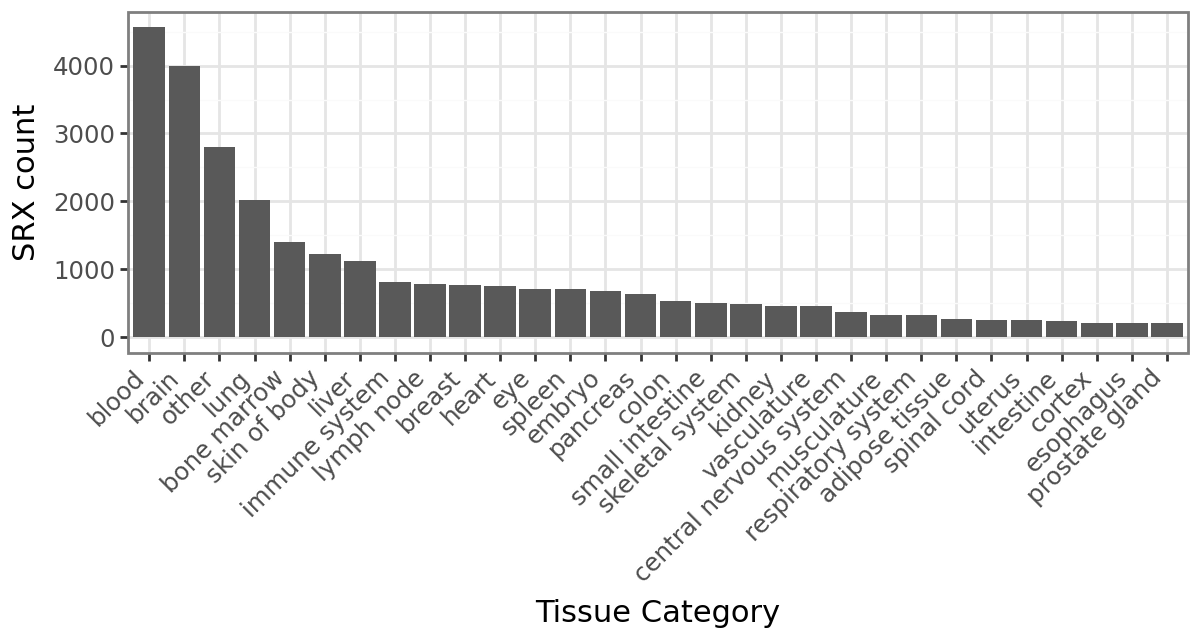

In [104]:
# plot histogram of tissue categories
## filter to top 30 categories
top30 = df_srx_meta["category"].value_counts().head(30).index
df = df_srx_meta[df_srx_meta["category"].isin(top30)].copy()
df["category"] = df["category"].to_list()

## order category by count
df["category"] = pd.Categorical(
    df["category"], 
    categories=df["category"].value_counts().index
)

# plot
p = (
    pn.ggplot(df, pn.aes(x="category")) +
    pn.geom_bar() +
    pn.labs(x="Tissue Category", y="SRX count") +
    pn.theme(
        axis_text_x=pn.element_text(angle=45, hjust=1),
        figure_size=(6, 3.2)
    )
)
p

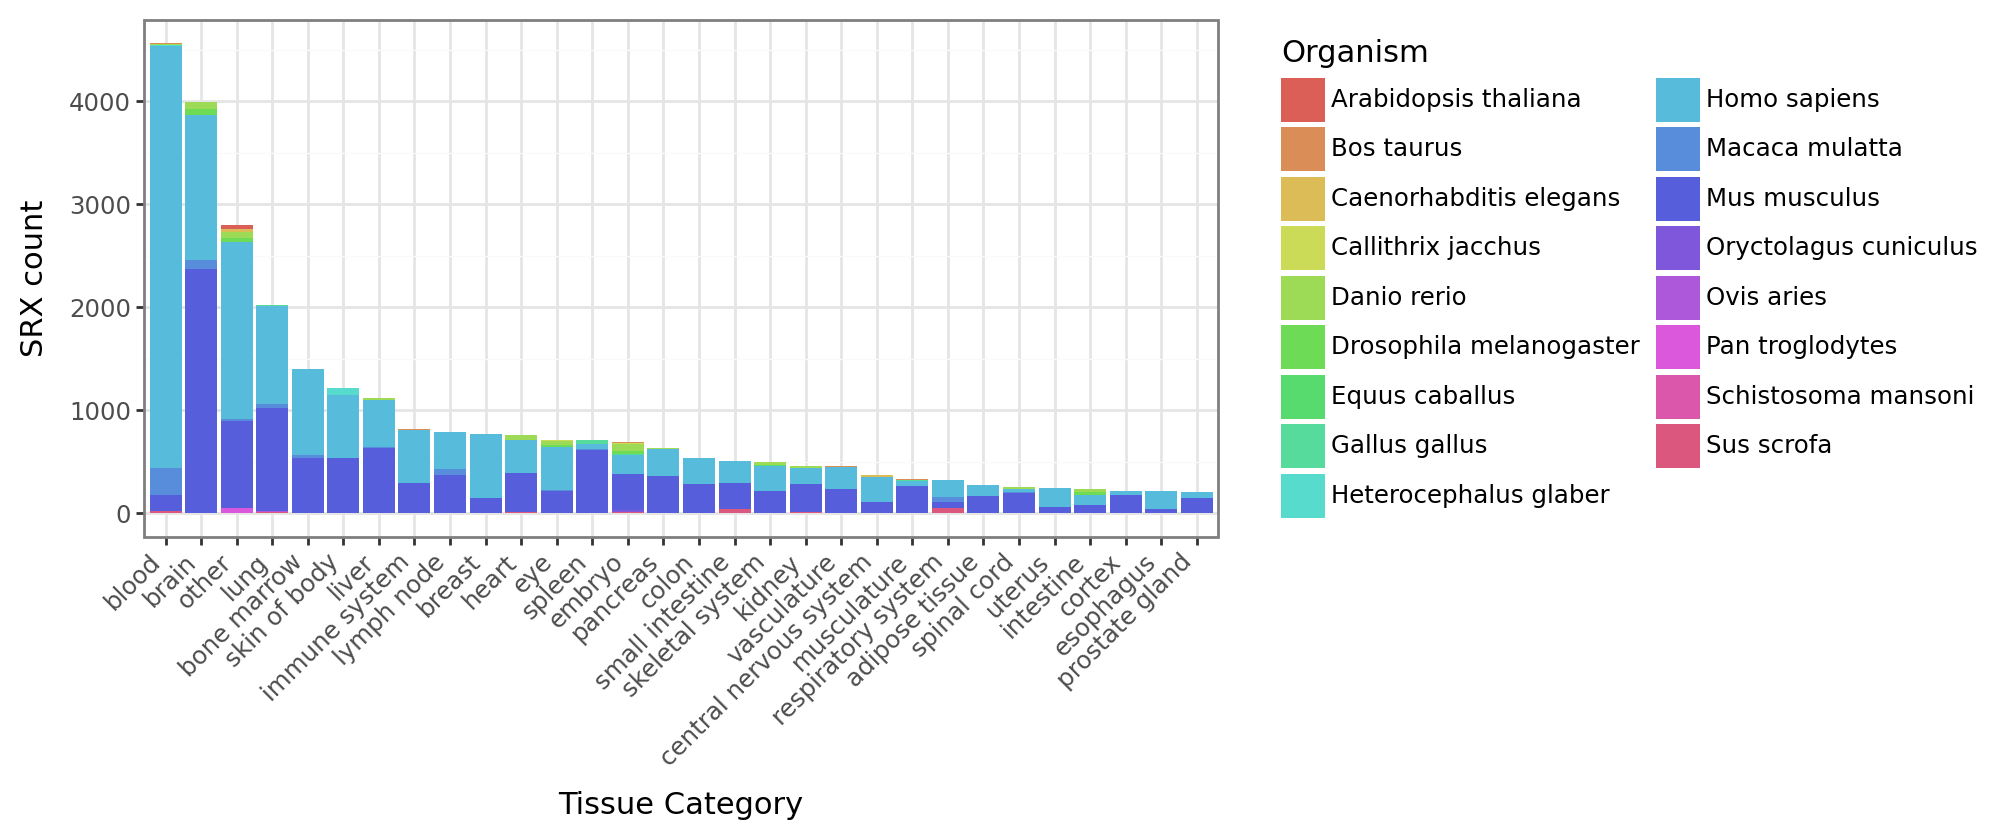

In [82]:
# plot histogram of tissue categories
## filter to top 30 categories
top30 = df_srx_meta["category"].value_counts().head(30).index
df = df_srx_meta[df_srx_meta["category"].isin(top30)].copy()

## order category by count
df["category"] = pd.Categorical(
    df["category"], 
    categories=df["category"].value_counts().index
)

# plot
p = (
    pn.ggplot(df, pn.aes(x="category", fill="organism")) +
    pn.geom_bar() +
    pn.labs(x="Tissue Category", y="SRX count", fill="Organism") +
    pn.theme(
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        figure_size=(10, 4.2),
        legend_key_height=1,
    ) 
)
p

## Animals, except human and mouse

In [87]:
other_animals = ['Macaca mulatta',
 'Sus scrofa',
 'Gallus gallus',
 'Drosophila melanogaster',
 'Equus caballus',
 'Pan troglodytes',
 'Heterocephalus glaber',
 'Callithrix jacchus',
 'Danio rerio',
 'Bos taurus',
 'Caenorhabditis elegans',
 'Oryctolagus cuniculus',
 'Ovis aries',
 'Schistosoma mansoni',
 'Gorilla gorilla']
other_animals

['Macaca mulatta',
 'Sus scrofa',
 'Gallus gallus',
 'Drosophila melanogaster',
 'Equus caballus',
 'Pan troglodytes',
 'Heterocephalus glaber',
 'Callithrix jacchus',
 'Danio rerio',
 'Bos taurus',
 'Caenorhabditis elegans',
 'Oryctolagus cuniculus',
 'Ovis aries',
 'Schistosoma mansoni',
 'Gorilla gorilla']

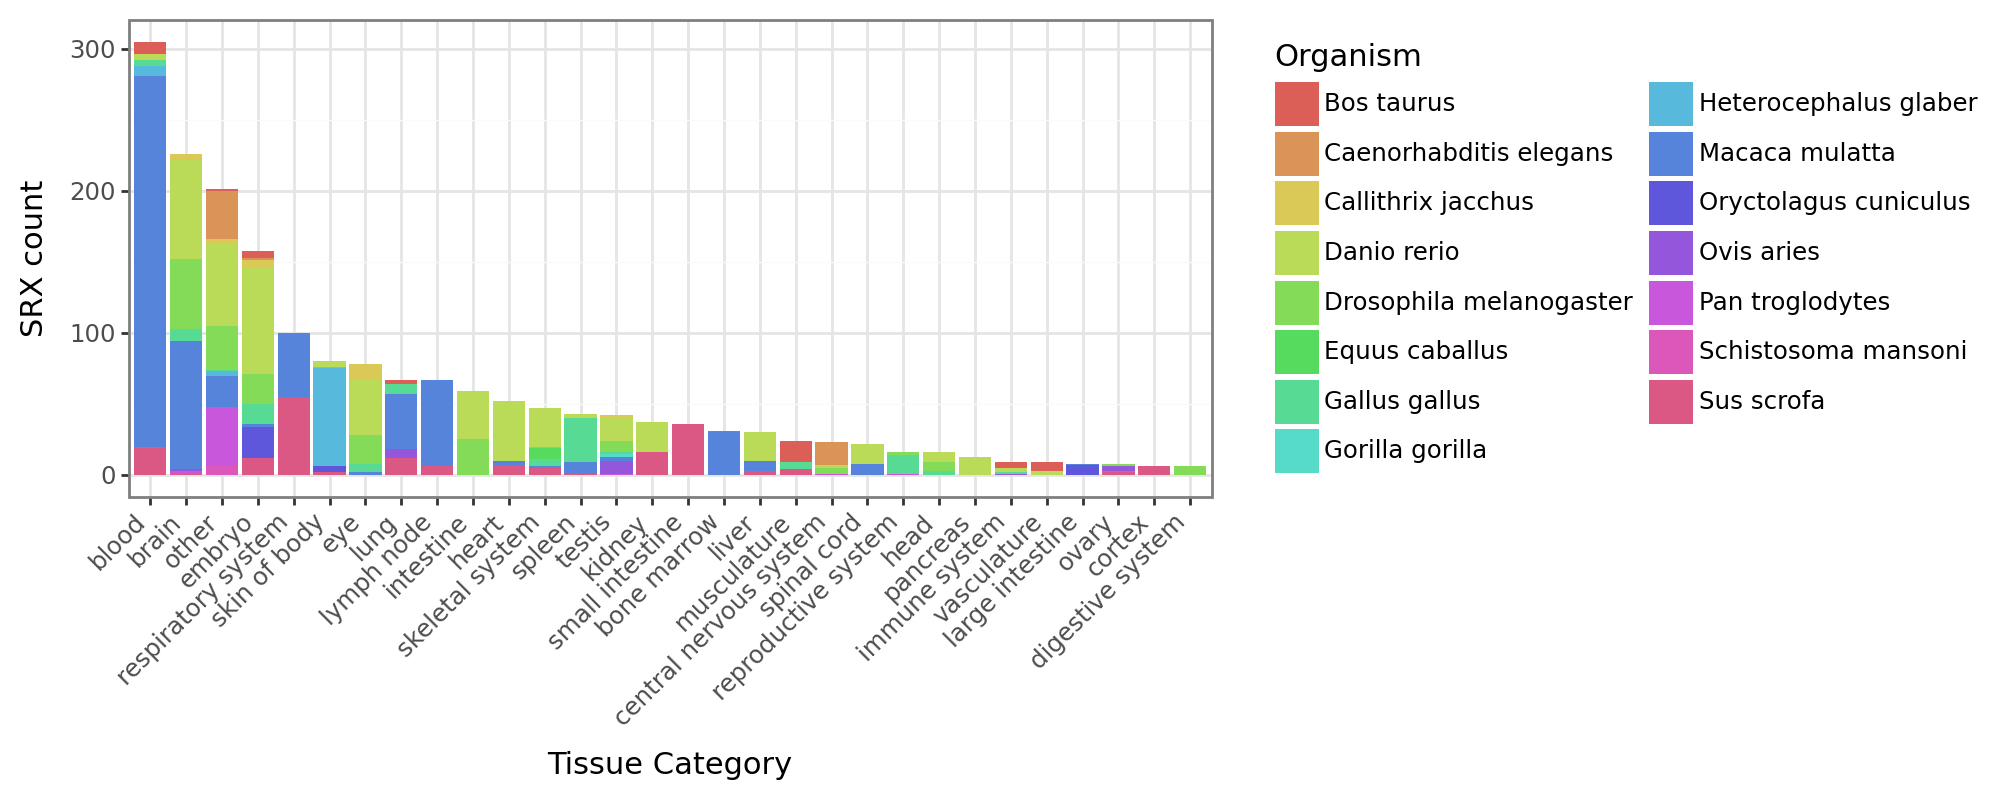

In [100]:
# plot histogram of tissue categories
## filter to target organisms
df = df_srx_meta[df_srx_meta["organism"].isin(other_animals)].copy()

## filter to top 30 categories
top30 = df["category"].value_counts().head(30).index
df = df[df["category"].isin(top30)]
df["category"] = df["category"].tolist()

## order category by count
df["category"] = pd.Categorical(
    df["category"], 
    categories=df["category"].value_counts().index
)

# plot
p = (
    pn.ggplot(df, pn.aes(x="category", fill="organism")) +
    pn.geom_bar() +
    pn.labs(x="Tissue Category", y="SRX count", fill="Organism") +
    pn.theme(
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        figure_size=(10, 4),
    ) +
    pn.guides(fill=pn.guide_legend(ncol=2))
)
p

## Just plants

In [64]:
plants = ["Arabidopsis thaliana", "Oryza sativa", "Solanum lycopersicum", "Zea mays"]

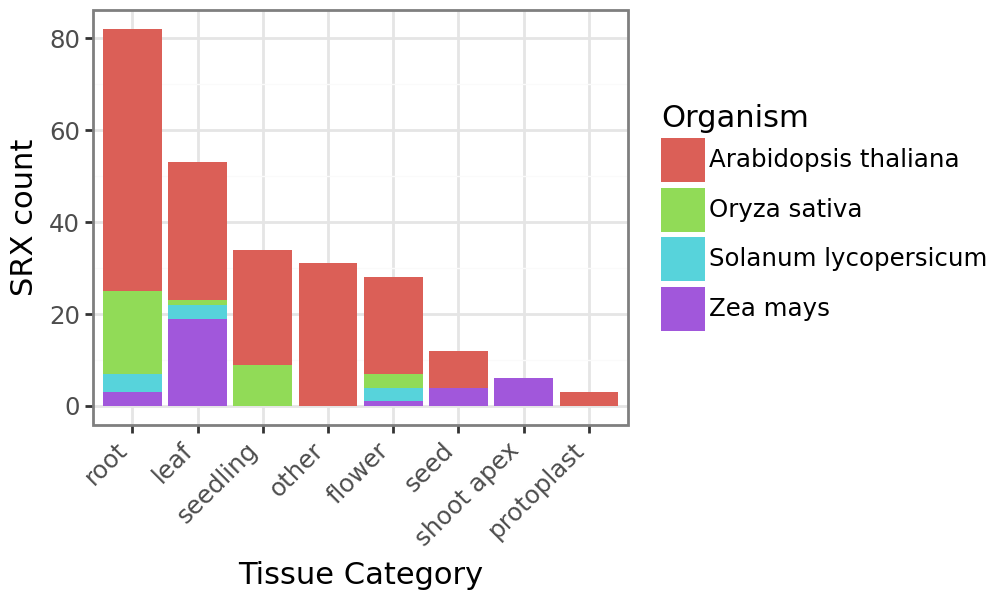

In [71]:
# plot histogram of tissue categories
## filter to plants
df = df_srx_meta[df_srx_meta["organism"].isin(plants)].copy()

## filter to top 30 categories
top30 = df["category"].value_counts().head(30).index
df = df[df["category"].isin(top30)]
df["category"] = df["category"].tolist()

## order category by count
df["category"] = pd.Categorical(
    df["category"], 
    categories=df["category"].value_counts().index
)

# plot
p = (
    pn.ggplot(df, pn.aes(x="category", fill="organism")) +
    pn.geom_bar() +
    pn.labs(x="Tissue Category", y="SRX count", fill="Organism") +
    pn.theme(
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        figure_size=(5, 3),
        legend_key_height=1,
    ) 
)
p